In [50]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import plotly.express as px

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

## Linear Regression
Linear regression is one of the most basic forms of machine learning and is used to *predict numeric values*. 

There are many tools within TensorFlow that could be used to solve the problems below. 

Using a linear model to predict the survival rate of passangers from the titanic dataset.

*This section is based on the following documentation: https://www.tensorflow.org/tutorials/estimator/linear*


Equation of a line in 2D.

$ y = mx + b $

Line of best fit for this graph.

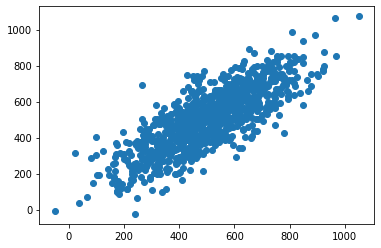

In [5]:
# Use numpy to generate a dataset of 1000 x,y coordinates that follow a normal distribution

# Range of x and y distribution
xx = np.array([0, 1000])
yy = np.array([0, 1000])

# Get the means of the range (for use in multivariate_normal method)
means = [xx.mean(), yy.mean()]  

# std deviations
stds = [xx.std() / 3, yy.std() / 3]

# correlation
corr = 0.8

# Covariance matrix of the distribution
covs = [[stds[0]**2, stds[0]*stds[1]*corr], 
         [stds[0]*stds[1]*corr, stds[1]**2]] 

# Distribution
m = np.random.multivariate_normal(means, covs, 1000).T

# Plot
plt.scatter(m[0], m[1])

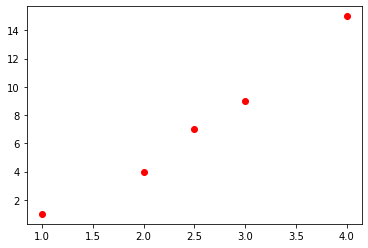

In [23]:
x = [1, 2, 2.5, 3, 4]
y = [1, 4, 7, 9, 15]
_ = plt.plot(x, y, 'ro')
plt.show()

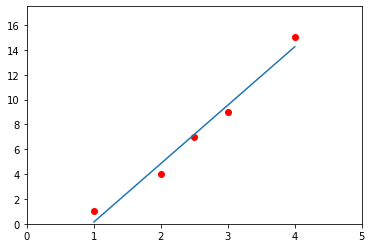

In [20]:
plt.axis([0, 5, 0, 17.5])
plt.plot(x, y, 'ro') # 'ro' for red circles
# line of best fit
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.show()

This regression line can be used to predict future values for our dataset. 

Just pass the **features** of the data point we would like to predict into the equation of the line and use the output as our prediction.

### Exploring and Cleaning Data

Using some built-in tools to explore the titanic dataset we will be focusing on here is the  dataset. 

In [44]:
# Load training dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') 


# Load the testing dataset
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') 


In [45]:
# The outcome we are interested in is whether the passengers survived or not. 
# so we can isolate that series of data to simply tell us if the person survived our not.

# Obtaining the series of survived data from the training data
y_train = dftrain.pop('survived')

# Obtaining the series of survived data from the evaluation data
y_eval = dfeval.pop('survived')

In [46]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

In [48]:
# Just putting that into human readable
y_traineng = y_train.map(lambda x : "Survived" if (x == 1) else "Dead") 
y_traineng.head()

0        Dead
1    Survived
2    Survived
3    Survived
4        Dead
Name: survived, dtype: object

In [55]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [84]:
df = dftrain.age
fig = px.histogram(df,
                   x="age",
                   labels={
                       'age':'Age',
                       'count':'Count'
                   },
                   nbins=20)
fig.show()

In [102]:
df = dftrain.sex.value_counts()
fig = px.bar(df, orientation='h')
fig.show()

In [107]:
df = dftrain['class'].value_counts() 
# interestingly dftrain.class doesn't work here because class is a Python keywork
fig = px.bar(df, orientation='h')
fig.show()

In [134]:
# Now let's get the survival rate for each sex
# first just restore the dataframe
df = pd.concat([dftrain, y_train], axis=1)
df.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone,survived
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n,0
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n,1
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y,1
3,female,35.0,1,0,53.1000,First,C,Southampton,n,1
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y,0


In [135]:
df = df.groupby('sex')['survived'].mean()
fig = px.bar(df, orientation='h',
            labels={
                'value':"% Survival Rate",
                'sex':"Sex",
                'male':'Male'
            },
            title="Survival Rate by Sex")
fig.show()

### Feature Columns
In our dataset we have two different kinds of information: **Categorical and Numeric**

Our **categorical data** is anything that is not numeric! For example, the sex column does not use numbers, it uses the words "male" and "female".

Before we continue and create/train a model we must convet our categorical data into numeric data. We can do this by encoding each category with an integer (ex. male = 1, female = 2). 

Fortunately for us TensorFlow has some tools to help!

In [136]:
# Identifying non-numeric columns 
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']

# Identifying numeric columns 
NUMERIC_COLUMNS = ['age', 'fare']

# make empty list for feature cols
feature_columns = []

# loop the cat cols to 
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
    # use tf.feature_column to get VocabularyListCategoricalColumn item in list
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    # use tf.feature_column to get representation of numeric columns as NumericColumn 
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

### Input Function
```tf.data.Dataset``` object is required by this TF model. This means we must create a **input function** that can convert our current pandas dataframe into that object. 

Below you'll see a seemingly complicated input function, this is straight from the TensorFlow documentation (https://www.tensorflow.org/tutorials/estimator/linear). I've commented as much as I can to make it understandble, but you may want to refer to the documentation for a detailed explination of each method.

In [160]:
def make_input_fn(data_df, label_df, num_epochs=100, shuffle=True, batch_size=32):
    """Returns a function object of input function for use"""
    def input_function():  # inner function, this will be returned
        """Takes  Pandas dataframe and its label and creates a tf.data.Dataset object"""
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df)) 
        if shuffle:
            ds = ds.shuffle(1000)  # randomize order of data
        ds = ds.batch(batch_size).repeat(num_epochs)  ## split dataset into batches of 32 and repeat process for number of epochs
        return ds  # return a batch of the dataset
    return input_function  # return a function object for use



In [157]:
# Using make_input_fn to create a train input function
# which can be called to create a dataset object we can feed to the model
train_input_fn = make_input_fn(dftrain, y_train)  

# Using make_input_fn to create an evaluation input function
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

### Creating the Model

Use a linear estimator to utilize the linear regression algorithm. 




In [158]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# We create a linear estimtor by passing the feature columns we created earlier

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpsrzhz_3c', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Training the Model
Training the model is as easy as passing the input functions that we created earlier.

In [159]:
# train the linear estimator
linear_est.train(train_input_fn)  

# Evaluate the model with evaluate method
# get model metrics/stats by testing on tetsing data
result = linear_est.evaluate(eval_input_fn)  

clear_output()  # clears console output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model

0.780303


And we now we have a model with a 74% accuracy (this will change each time)! Not crazy impressive but decent for our first try.

Now let's see how we can actually use this model to make predicitons.

We can use the ```.predict()``` method to get survival probabilities from the model. This method will return a list of dicts that store a predicition for each of the entries in our testing data set. Below we've used some pandas magic to plot a nice graph of the predictions.

As you can see the survival rate is not very high :/

In [161]:
pred_dicts = list(linear_est.predict(eval_input_fn))


INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpsrzhz_3c/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[{'logits': array([-2.5388134], dtype=float32),
  'logistic': array([0.07318163], dtype=float32),
  'probabilities': array([0.9268184 , 0.07318162], dtype=float32),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object)},
 {'logits': array([0.17630282], dtype=float32),
  'logistic': array([0.5439619], dtype=float32),
  'probabilities': array([0.45603812, 0.54396194], dtype=float32),
  'class_ids': array([1]),
  'classes': array([b'1'], dtype=object),
  'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object)},
 {'logits': array([1.192032], dtype=float32),
  'logistic': array([0.76710427], dtype=float32),
  'probabilities': array([0.23289572, 0.7671043 ], dtype=float32),
  'class_ids': array([1]),
  'classes': array([b'1'], dtype=object),
  'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object)},
 

In [181]:
# Extract the probabilities 
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
probs.rename('probabilities',inplace=True)

0      0.073182
1      0.543962
2      0.767104
3      0.615301
4      0.237978
         ...   
259    0.827902
260    0.078051
261    0.294093
262    0.176253
263    0.442519
Name: probabilities, Length: 264, dtype: float64

In [182]:
fig = px.histogram(probs, nbins=20, 
                   x='probabilities',
                   title='Predicted Probabilities of Survival')
fig.show()